In [1]:
from models import UMNNMAFFlow
import torch
from torch.utils.data import DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
import lib.toy_data as toy_data
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import os
import lib.utils as utils
import lib.visualize_flow as vf

In [33]:
def sample_p_z(size, dim=2):
    means =  torch.zeros(size, dim)
    cov =  torch.eye(dim)
    
    m = MultivariateNormal(means, cov)
    return m.sample()

In [2]:
device = "cpu"

# Dataset 

In [44]:
toy_dataset = "conditionnal8gaussians"

In [45]:
batch_size = 100
num_data = 10000

y_dim = latent_dim = 2
x_dim = 8 # Conditionning variable dim

y_train, x_train = toy_data.inf_train_gen(toy_dataset, batch_size=num_data)
y_test, x_test = toy_data.inf_train_gen(toy_dataset, batch_size=1000)

train_dataloader = DataLoader(torch.cat((torch.tensor(y_train), torch.tensor(x_train).type(torch.FloatTensor)), 1), batch_size=batch_size)
test_dataloader = DataLoader(torch.cat((torch.tensor(y_test), torch.tensor(x_test).type(torch.FloatTensor)), 1), batch_size=batch_size)

# Model

In [46]:
nb_steps=20
nb_flow=1

model = UMNNMAFFlow(nb_flow=nb_flow, 
                    nb_in=y_dim, 
                    cond_in=x_dim,
                    hidden_derivative=[100, 100, 100, 100], 
                    hidden_embedding=[100, 100, 100, 100],
                    embedding_s=10, 
                    nb_steps=nb_steps, 
                    device=device).to(device)

# Training

In [47]:
opt = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5)

epoch: 0 - Train loss: 3.680571 - Test loss: 2.316918
0


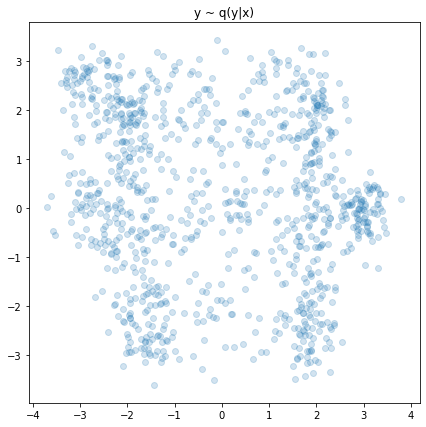

epoch: 10 - Train loss: 0.779168 - Test loss: 0.743841
0


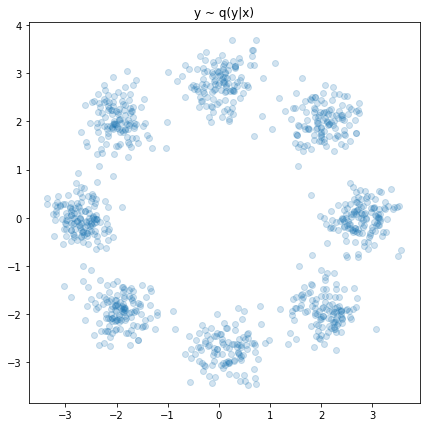

epoch: 20 - Train loss: 0.769546 - Test loss: 0.727714
0


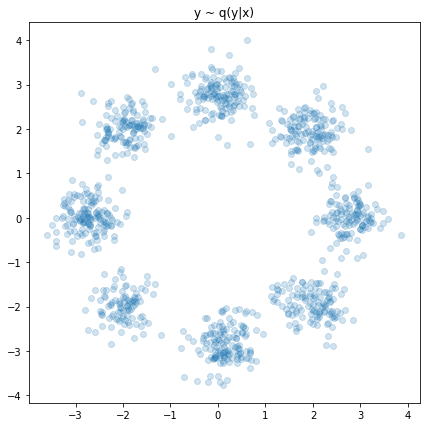

epoch: 30 - Train loss: 0.765172 - Test loss: 0.727725
0


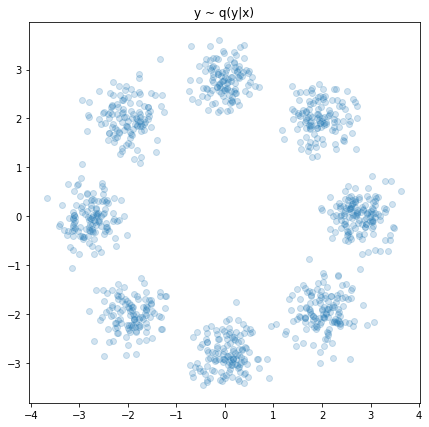

epoch: 40 - Train loss: 0.762750 - Test loss: 0.729288
0


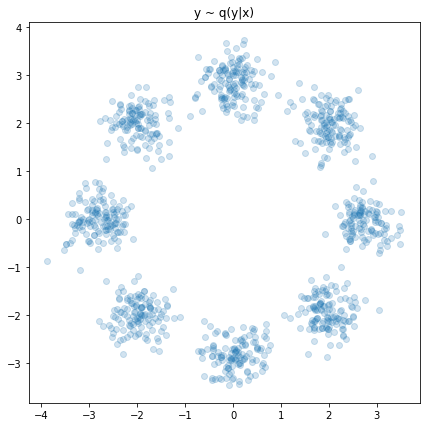

epoch: 50 - Train loss: 0.760871 - Test loss: 0.730986
0


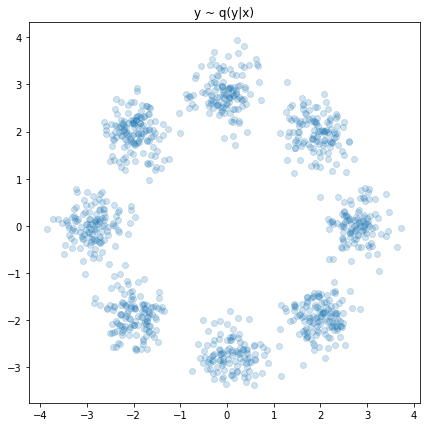

epoch: 60 - Train loss: 0.759374 - Test loss: 0.731879
0


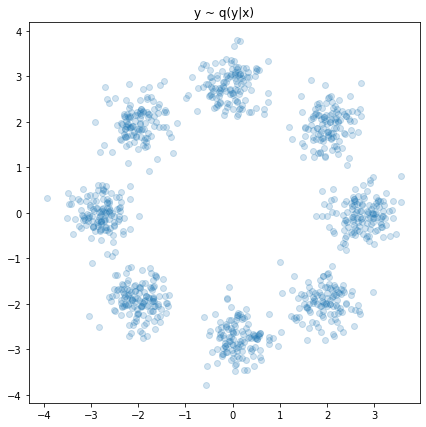

epoch: 70 - Train loss: 0.758181 - Test loss: 0.731367
0


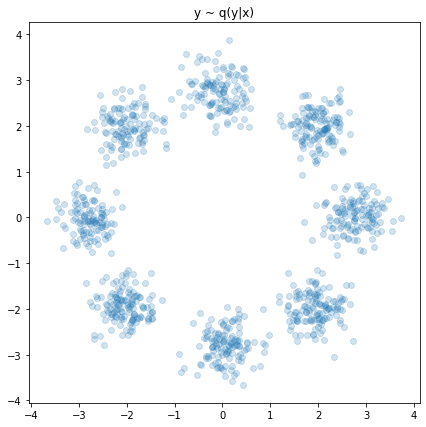

epoch: 80 - Train loss: 0.757772 - Test loss: 0.732966
0


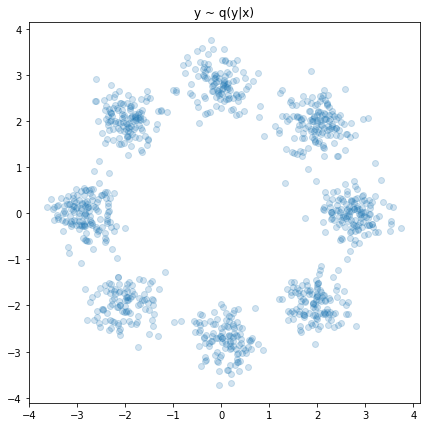

epoch: 90 - Train loss: 0.756730 - Test loss: 0.730545
0


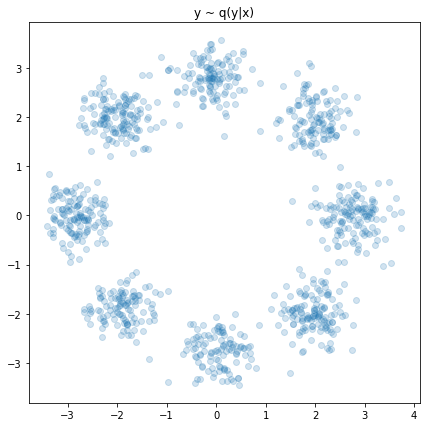

In [48]:
print_every = 10
nb_epoch = 100
training_loss = []
testing_loss = []

for epoch in range(nb_epoch):
    
    # Training
    train_loss = 0    
    for batch in train_dataloader:
        y = batch[:, :y_dim]
        x = batch[:, y_dim:]
        ll, z = model.compute_ll(y, context=x)
        ll = -ll.mean()
        train_loss += ll.detach()/(batch_size/batch.shape[0])/len(train_dataloader)
        loss = ll
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    # Compute Test Loss    
    test_loss = 0  
    for batch in test_dataloader:
        y = batch[:, :y_dim]
        x = batch[:, y_dim:]
        ll_test, _ = model.compute_ll(y, context=x)
        ll_test = -ll_test.mean()
        test_loss += ll_test.detach()/(batch_size/batch.shape[0])/len(test_dataloader)
    
    training_loss.append(train_loss)
    testing_loss.append(test_loss)

    if (epoch % print_every) == 0:
        print("epoch: {:d} - Train loss: {:4f} - Test loss: {:4f}".
                format(epoch, train_loss.item(), test_loss.item()))
        
        fig = plt.figure(figsize=(7, 7))
        z = sample_p_z(1000)
        _, x = toy_data.inf_train_gen(toy_dataset, batch_size=1000)
        y = model.invert(z, context=torch.tensor(x).type(torch.FloatTensor))
        plt.scatter(y[:, 0], y[:, 1], alpha=0.2);
        plt.title('y ~ q(y|x)');
        plt.show()

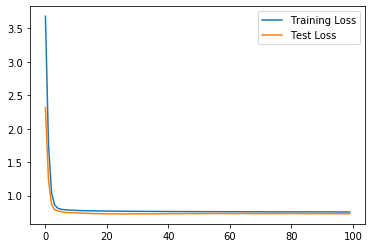

In [49]:
plt.plot(training_loss, label='Training Loss')
plt.plot(testing_loss, label='Test Loss')
plt.legend()

# Sample from the model

0
0
0
0
0
0
0
0


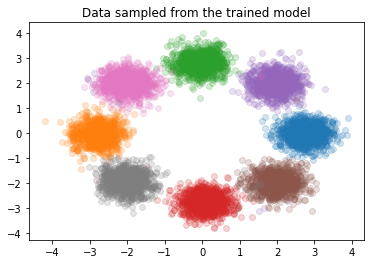

In [54]:
for i in range(x_dim):
    z = sample_p_z(1000)
    x = torch.zeros(1000, 8)
    x[:,i] = 1.
    y = model.invert(z, context=x)
    plt.scatter(y[:, 0], y[:, 1], alpha=0.2);
plt.title('Data sampled from the trained model');
plt.show()